# Computing the energy density of the Glasma in the MV model

In this notebook we compute the energy density of the Glasma in the MV model and compare the result to Tuomas Lappi's value from 2006 (see [**arXiv:hep-ph/0606207**](https://arxiv.org/abs/hep-ph/0606207)). By reproducing the same energy density we can be sure that our code works correctly. At $\tau_0 = 1.0 / g^2 \mu$ we obtain $\varepsilon(\tau_0) = 0.262 (g^2 \mu)^4 / g^2 $ which translates to $\varepsilon(\tau_0) = 136 \, \mathrm{GeV} / \mathrm{fm}^3$ for $g^2 \mu = 2.0 \, \mathrm{GeV}$ and $\varepsilon(\tau_0) = 691 \, \mathrm{GeV} / \mathrm{fm}^3$ for $g^2 \mu = 3.0 \, \mathrm{GeV}$. The numbers from [**arXiv:hep-ph/0606207**](https://arxiv.org/abs/hep-ph/0606207) are $130 \, \mathrm{GeV} / \mathrm{fm}^3$ and $700 \, \mathrm{GeV} / \mathrm{fm}^3$. Close enough.

In [1]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "numba"
os.environ["GAUGE_GROUP"] = "su2"
os.environ["PRECISION"] = "double"

# Import curraun and other packages
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
from curraun.energy import Energy
from curraun.lyapunov import Lyapunov
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

import numpy as np
import pickle, datetime
from tqdm import tqdm
import copy

# define hbar * c in units of GeV * fm
hbarc = 0.197326 

Using Numba
Using SU(2)
Using double precision
Using double precision
Using double precision


In [2]:
def compute(p):    
    # output dictionary
    output = {}
    output["energy"] = []
    
    output["EL"] = []
    output["BL"] = []
    output["ET"] = []
    output["BT"] = []
    
    output["pL"] = []
    output["pT"] = []
    
    # derived parameters
    a = p['L'] / p['N']
    E0 = p['N'] / p['L'] * hbarc
    DT = 1.0 / p['DTS']
    maxt = int(p['TMAX'] / a) * p['DTS']
    
    start_t = 1
    
    # event loop
    for e in range(p['NE']):
        print("Simulating event {} of {}".format(e+1, p['NE']))

        # initialization
        s = core.Simulation(p['N'], DT, p['G'])
        va = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        vb = mv.wilson(s, mu=p['MU'] / E0, m=p['M'] / E0, uv=p['UV'] / E0, num_sheets=p['NS'])
        initial.init(s, va, vb)

        # initialize energy computation
        en = Energy(s)

        # copy of s
        sprime = copy.deepcopy(s)

        # ed for sprime
        enp = Energy(sprime)

        # initialize Lyapunov computation
        ly = Lyapunov(s, sprime)
        
        # change el field
        peta1 = sprime.peta1.copy()
        print('peta1_before', peta1[0, :])

        alpha = 0.1
        #TODO: implement alpha Gaussian noise in change_el() from lyapynov.py
        ly.change_el(alpha)

        peta1 = sprime.peta1.copy()
        print('peta1_after', peta1[0, :])

        # temporary results

        EL = []
        BL = []
        ET = []
        BT = []

        energy = []
        pL = []
        pT = []

        taus = []

        if use_cuda:
            s.copy_to_device()
            meminfo = cuda.current_context().get_memory_info()
            # print("CUDA free memory: {:.2f} GB of {:.2f} GB.".format(meminfo[0] / 1024 ** 3, meminfo[1] / 1024 ** 3))

        for t in tqdm(range(maxt)):
            core.evolve_leapfrog(s)

            # evole sprime copy of s with el changed
            # core.evolve_leapfrog(sprime)

            if t >= start_t:
                # unit factors (GeV^2)
                units = E0 ** 2 / (s.g ** 2)

                # color factors (for quarks)
                Nc = core.su.NC
                f = 2 * s.g ** 2 / (2 * Nc)

                # Energy density calculation
                en.compute()

                # Energy density for sprime
                # enp.compute()

                # unit factors (GeV^3)
                units = E0 ** 4
                EL.append(en.EL_mean * units)
                BL.append(en.BL_mean * units)
                ET.append(en.ET_mean * units)
                BT.append(en.BT_mean * units)

                # unit factors (Gev / fm^3)
                units = E0 ** 4 / hbarc ** 3
                energy.append(en.energy_density * units)

                pL.append(en.pL * units)
                pT.append(en.pT * units)

                taus.append(t)

        energy = np.array(energy)

        EL = np.array(EL)
        BL = np.array(BL)
        ET = np.array(ET)
        BT = np.array(BT)

        pL = np.array(pL)
        pT = np.array(pT)

        output["energy"].append(energy)

        output["EL"].append(EL)
        output["BL"].append(BL)
        output["ET"].append(ET)
        output["BT"].append(BT)

        output["pL"].append(pL)
        output["pT"].append(pT)
            
    # perform average over events
    
    # also add standard deviations
    output["energy_std"] = np.std(np.array(output["energy"]), axis=0)
    
    output["EL_std"] = np.std(np.array(output["EL"]), axis=0)
    output["BL_std"] = np.std(np.array(output["BL"]), axis=0)
    output["ET_std"] = np.std(np.array(output["ET"]), axis=0)
    output["BT_std"] = np.std(np.array(output["BT"]), axis=0)
    
    output["pL_std"] = np.std(np.array(output["pL"]), axis=0)
    output["pT_std"] = np.std(np.array(output["pT"]), axis=0)
    
    # compute means
    output["energy"] = np.mean(np.array(output["energy"]), axis=0)
    
    output["EL"] = np.mean(np.array(output["EL"]), axis=0)
    output["BL"] = np.mean(np.array(output["BL"]), axis=0)
    output["ET"] = np.mean(np.array(output["ET"]), axis=0)
    output["BT"] = np.mean(np.array(output["BT"]), axis=0)
    
    output["pL"] = np.mean(np.array(output["pL"]), axis=0)
    output["pT"] = np.mean(np.array(output["pT"]), axis=0)
    
    # more useful stuff
    output["tau"] = np.array(taus) / np.max(taus) * p["TMAX"]
    output["E0"] = E0
    
    if use_cuda:
        cuda.current_context().deallocations.clear()
    
    return output

In [3]:
# We compute everything for g^2 \mu = 1 GeV and then rescale the results.

g2mu = 1.0                     # [GeV]
RA = 67.7 / (g2mu / hbarc)     # Radius of the nucleus in [fm]
F = np.pi * RA ** 2            # Transverse area [fm^2]
L = np.sqrt(F)                 # Length of the simulation box [fm]
g = 2.0                        # Coupling constant
mu = g2mu / g ** 2             # MV model parameter [GeV]
m = 0.00001                    # No infrared regulation, except global charge neutrality
tau_max = 10.0 / g2mu * hbarc  # Maximum proper time

p_lappi = {    
    'L':    L,                 # transverse size [fm]
    'N':    64,              # lattice size
    'DTS':  4,                # time steps per transverse spacing
    'TMAX': tau_max,           # max. proper time (tau) [fm/c]

    'G':    g,                 # YM coupling constant
    'MU':   mu,                # MV model parameter [GeV]
    'M':    m,                 # IR regulator [GeV]
    'UV':   100000.0,          # UV regulator [GeV]
    'NS':   1,                 # number of color sheets

    'NE':   1,                # number of events
}

from time import time
t1 = time()
r_lappi = compute(p_lappi)
t2 = time()

print("{:3.2f}s".format(t2-t1))

Simulating event 1 of 1
peta1_before [ 0.          0.03157474 -0.07405436 -0.03842601]
peta1_after [ 0.          0.03473222 -0.08145979 -0.04226862]


100%|██████████| 20/20 [00:01<00:00, 12.76it/s]

5.79s


In [4]:
import matplotlib.pyplot as plt

from matplotlib import rc
# rc('text', usetex=True)
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size':18})

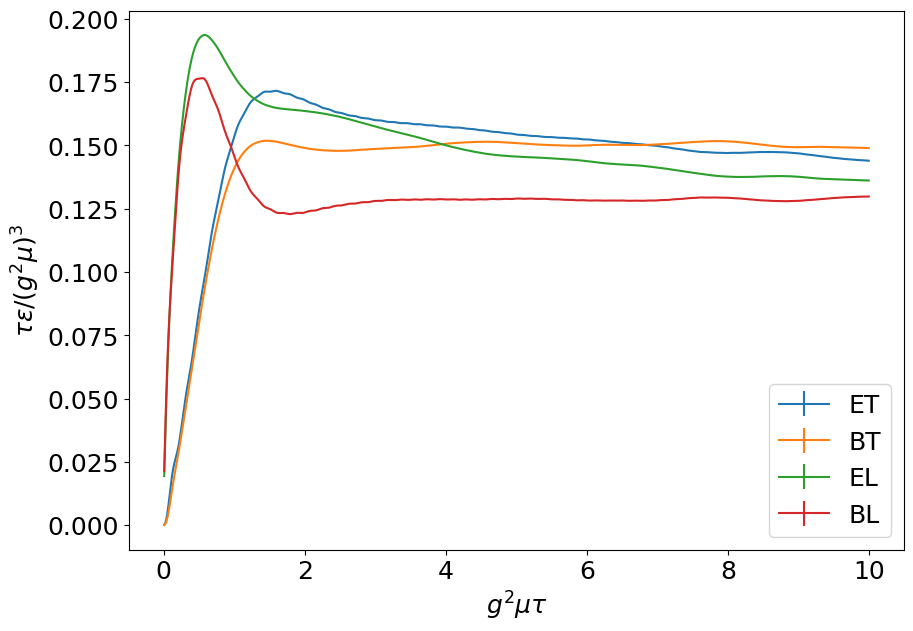

In [10]:
r = r_lappi
tau = r["tau"] / hbarc
plt.errorbar(tau, r["ET"], yerr=r["ET_std"], errorevery=100, label="ET")
plt.errorbar(tau, r["BT"], yerr=r["BT_std"], errorevery=100, label="BT")
plt.errorbar(tau, r["EL"], yerr=r["EL_std"], errorevery=100, label="EL")
plt.errorbar(tau, r["BL"], yerr=r["BL_std"], errorevery=100, label="BL")

plt.ylabel(r"$\tau \varepsilon / (g^2 \mu)^3$")
plt.xlabel(r"$g^2 \mu \tau$")
plt.legend()
plt.show()
#plt.ylabel("$\\tau \epsilon \quad [ \mathrm{GeV} / \mathrm{fm}^2 ]$")

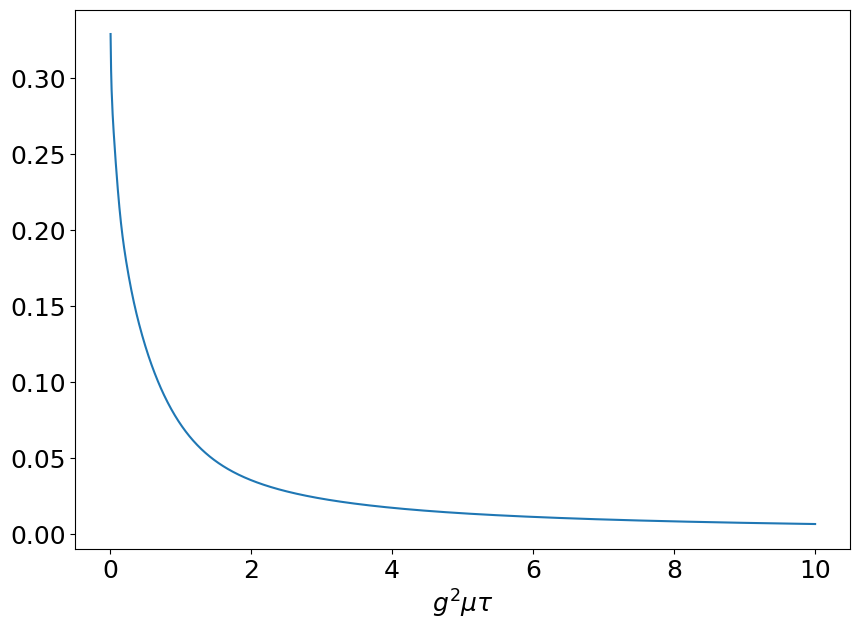

In [11]:
plt.errorbar(tau, r["energy"] * hbarc ** 3, yerr=r["energy_std"] * hbarc ** 3, errorevery=20)
plt.xlabel(r"$g^2 \mu \tau$")
plt.show()

In [18]:
# energy density at specific tau
tau_eval = 1.0
tau_eval_index = np.argmin(np.abs(tau - tau_eval))
energy_dimless = r["energy"][tau_eval_index] * hbarc ** 3 * g ** 2

print(r"\varepsilon(\tau_0) = {} (g^2 \mu)^4 / g^2".format(energy_dimless))

\varepsilon(\tau_0) = 0.28847029295050336 (g^2 \mu)^4 / g^2


In [19]:
energy_RHIC = energy_dimless * 2.0 ** 4 / hbarc ** 3 / g ** 2
energy_LHC = energy_dimless * 3.0 ** 4 / hbarc ** 3 / g ** 2

print("Energy density at 'RHIC': {} GeV/fm^3".format(energy_RHIC))
print("Energy density at 'LHC': {} GeV/fm^3".format(energy_LHC))

Energy density at 'RHIC': 150.17863400802358 GeV/fm^3
Energy density at 'LHC': 760.2793346656194 GeV/fm^3
